In [1]:
import tushare as ts
import pandas as pd 
import numpy as np
from heapq import nlargest
from heapq import nsmallest
#方式一
ts.set_token('4b17f7dee1a1566c34c3f3a0471168a74f03bcc91d2706c40221bb21')
pro = ts.pro_api()

In [2]:
df = pro.daily(ts_code='000001.SZ', start_date='20181230', end_date='20191230')

In [3]:
df.sort_index(ascending=False, inplace=True)

In [4]:
df.reset_index(inplace=True)

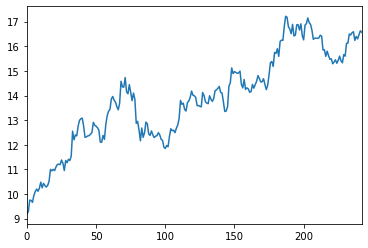

In [5]:
df['close'].plot()

In [225]:
def bollinger_bands(df, price_name='close', window=20, std_times=2):
    # Middle Band = 20-day simple moving average (SMA)
    # Upper Band = 20-day SMA + (20-day standard deviation of price x 2) 
    # Lower Band = 20-day SMA - (20-day standard deviation of price x 2)

    #Calculate rolling mean and standard deviation using number of days set above
    rolling_mean = df[price_name].rolling(window).mean()
    rolling_std = df[price_name].rolling(window).std()

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    ret_df = pd.DataFrame()
    ret_df[price_name] = df[price_name]
    ret_df['Middle_Band'] = rolling_mean
    ret_df['Upper_Band'] = rolling_mean + (rolling_std * std_times)
    ret_df['Lower_Band'] = rolling_mean - (rolling_std * std_times)
    # ((Upper Band - Lower Band) / Middle Band) * 100
    ret_df['Band_Width'] = ( (ret_df['Upper_Band'] - ret_df['Lower_Band']) / ret_df['Middle_Band']) * 100
    # %B = (Price - Lower Band)/(Upper Band - Lower Band)
    ret_df['Percent_Band'] =  (df[price_name] - ret_df['Lower_Band']) / (ret_df['Upper_Band'] -ret_df['Lower_Band'])
    
    return ret_df

In [47]:
def adl(df):
    # 1. Money Flow Multiplier = [(Close  -  Low) - (High - Close)] /(High - Low) 
    flow_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close']))/(df['high'] - df['low'])
    
    # 2. Money Flow Volume = Money Flow Multiplier x Volume for the Period
    flow_vol = flow_multiplier * df['vol']

    # 3. ADL = Previous ADL + Current Period's Money Flow Volume
    adl = flow_vol.rolling(2).sum()
    ret_df = pd.DataFrame()
    ret_df['close'] = df['close']
    ret_df['flow_multiplier'] = flow_multiplier
    ret_df['adl'] = adl
    return ret_df

In [83]:
def aroon(df, n=25):
    # Aroon-Up = ((25 - Days Since 25-day High)/25) x 100
    # Aroon-Down = ((25 - Days Since 25-day Low)/25) x 100
    # Aroon Oscillator = Aroon-Up  -  Aroon-Down
    up = 100 * (25 - df['close'].rolling(n).apply(lambda x: x.argmax(), raw=True))/n
    down = 100 * (25 - df['close'].rolling(n).apply(lambda x: x.argmin(), raw=True))/n
    oscillator = up -down
    return pd.DataFrame(dict(up=up, down=down, oscillator=oscillator))

In [217]:
def true_range(df, period=14):
    tr = (np.maximum((df['high'] - df['low']), abs(df['high'] - df['pre_close']))).rolling(period).sum()
    atr = tr/period
    return tr, atr

In [314]:
def adx(df, period=14):
    '''
    TR = SUM(MAX(MAX(HIGH - LOW, ABS(HIGH-REF(CLOSE,1))), ABS(LOW - REF(CLOSE, 1))), N)
    HD = HIGH - REF(HIGH, 1)
    LD = REF(LOW, 1) - LOW
    DMP = SUM(IF(HD>0 AND HD>LD, HD, 0), N)
    DMM = SUM(IF(LD>0 AND LD>HD, LD, 0), N)
    PDI = DMP*100/TR
    MDI = DMM*100/TR
    DX = ABS(MDI - PDI)/(MDI + PDI)*100
    ADX = MA(ABS(MDI - PDI)/(MDI + PDI)*100, M)
    REF(X, N)：引用X在N个周期前的值
    '''
    #tr = (np.maximum((df['high'] - df['low']), abs(df['high'] - df['pre_close']))).rolling(period).sum()
    tr, atr = true_range(df, period)
    hd = df['high'].diff()
    ld = df['low'].diff(-1)
    ld[1:] = ld[:-1]
    ld[0]=np.nan
    dmp = pd.Series([(x if c else 0) for x,c in zip(hd,(hd>0) & (hd>ld))]).rolling(period).sum()
    dmm = pd.Series([(x if c else 0) for x,c in zip(ld,(ld>0) & (ld>hd))]).rolling(period).sum()
    pdi = dmp*100/TR
    mdi = dmm*100/TR
    dx = np.abs(mdi - pdi)/(mdi + pdi) *100
    adx = dx.rolling(period).mean()
    return pd.DataFrame(dict(adx=adx, pdi=pdi, mdi=mdi))

In [252]:
def cmf(df, period=20):
    # 1. Money Flow Multiplier = [(Close  -  Low) - (High - Close)] /(High - Low) 
    # 2. Money Flow Volume = Money Flow Multiplier x Volume for the Period
    # 3. 20-period CMF = 20-period Sum of Money Flow Volume / 20 period Sum of Volume 
    multiplier = ((df['close']-df['low']) - (df['high'] - df['close']))/(df['high'] - df['low'])
    flow_vol = multiplier * df['vol']
    cmf = flow_vol.rolling(period).sum()/ df['vol'].rolling(period).sum()
    return pd.DataFrame(dict(cmf=cmf))
    

In [263]:
def chaikin_oscillator(df):
    # Chaikin Oscillator = (3-day EMA of ADL)  -  (10-day EMA of ADL)
    df_adl = adl(df)
    #EMA: pd.ewm()
    co = df_adl['adl'].ewm(span=3, adjust=False).mean() - df_adl['adl'].ewm(span=10, adjust=False).mean()
    return co

In [ ]:
def ctm(df):
    # Bollinger bands in four different timeframes (20-day, 50-day, 75-day and 100-day)
    # The price change relative to the standard deviation over the past 100 days
    # The 14-day RSI value
    # The existence of any short-term (2-day) price channel breakouts

In [345]:
def rsi(df, period=14):
    '''            
                      100
        RSI = 100 - --------
                     1 + RS

        RS = Average Gain / Average Loss
    ''' 

    gain_avg = df['change'].rolling(period).apply(lambda x:sum(p for p in x if p > 0), raw=True)/period
    loss_avg = -1*df['change'].rolling(period).apply(lambda x:sum(n for n in x if n < 0), raw=True)/period
    rs = gain_avg / loss_avg
    rsi = 100 - 100/(1+rs)
    return rsi

In [348]:
def price_channel(df, period=20):
    # Upper Channel Line: 20-day high
    # Lower Channel Line: 20-day low
    # Centerline: (20-day high + 20-day low)/2 
    upper_channel = df['high'].rolling(period).max()
    lower_channel = df['low'].rolling(period).max()
    center_line = (upper_channel + lower_channel)/2
    return pd.DataFrame(dict(upper_channel=upper_channel, lower_channel=lower_channel, center_line=center_line))

In [359]:
def cci(df, period=20):
    # CCI = (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
    # Typical Price (TP) = (High + Low + Close)/3
    # Constant = .015
    # There are four steps to calculating the Mean Deviation: 
    # First, subtract the most recent 20-period average of the typical price from each period's typical price. 
    # Second, take the absolute values of these numbers. 
    # Third, sum the absolute values. 
    # Fourth, divide by the total number of periods (20).
    c = 0.015
    typical_price = (df['high'] + df['low'] + df['close'])/3
    md = typical_price.rolling(period).apply(lambda x: abs(x-x.mean()).sum(), raw=True)/period
    cci = (typical_price - typical_price.rolling(period).mean()) / (c * md)
    return cci


In [7]:
def roc(df, period=10):
    '''
    ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100
    '''
    
    roc = 100 * df['close'].diff(period) / df['close'].shift(period)
    return roc

In [32]:
def coppock_curve(df):
    '''
    Coppock Curve = 10-period WMA of (14-period RoC + 11-period RoC)
    WMA = Weighted Moving Average
    RoC = Rate-of-Change
    '''
    roc_14 = roc(df, 14)
    roc_11 = roc(df, 11)
    weight = np.arange(1, 11)
    cv = (roc_14 + roc_11).rolling(10).apply(lambda x:np.average(x, weights=weight), raw=True)
    return cv

In [ ]:
def custom_smoothing_function(serise, period):
    multiplier = 2/period
    

In [ ]:
def pmo(df, period):
    '''
    Price Momentum Oscillator
    Smoothing Multiplier = (2 / Time period)
    Custom Smoothing Function = {Close - Smoothing Function(previous day)} *
    Smoothing Multiplier + Smoothing Function(previous day) 

    PMO Line = 20-period Custom Smoothing of
    (10 * 35-period Custom Smoothing of
    ( ( (Today's Price/Yesterday's Price) * 100) - 100) )

    PMO Signal Line = 10-period EMA of the PMO Line
    '''
    

In [45]:
def dpo(df, period=20):
    '''
    Detrended Price Oscillator (DPO) = Price {X/2 + 1} periods ago - the X-period simple moving average.
    '''
    dpo = df['close'].shift(int(period/2+1))- df['close'].rolling(period).mean()
    return dpo

In [61]:
def emv(df, period=14):
    '''
    Distance Moved = ((H + L)/2 - (Prior H + Prior L)/2) 

    Box Ratio = ((V/100,000,000)/(H - L))

    1-Period EMV = ((H + L)/2 - (Prior H + Prior L)/2) / ((V/100,000,000)/(H - L))

    14-Period Ease of Movement = 14-Period simple moving average of 1-period EMV
    '''
    distanc_moved = ((df['high']+df['low'])/2).diff()
    box_ratio = (df['vol']/1000000)/(df['high']-df['low'])
    period_1_emv = distanc_moved/box_ratio
    emv_period = period_1_emv.rolling(period).mean()
    return emv_period

In [70]:
def force_index(df, period=13):
    '''
    Force Index(1) = {Close (current period)  -  Close (prior period)} x Volume
    Force Index(13) = 13-period EMA of Force Index(1)
    '''
    force_index_1 = df['change'] *df['vol']
    force_index_period = force_index_1.ewm(span=period, adjust=False).mean()
    return force_index_period

In [74]:
def mass_index(df):
    '''
    Single EMA = 9-period exponential moving average (EMA) of the high-low differential  

    Double EMA = 9-period EMA of the 9-period EMA of the high-low differential 

    EMA Ratio = Single EMA divided by Double EMA 

    Mass Index = 25-period sum of the EMA Ratio 
    '''
    single_ema = (df['high']-df['low']).ewm(span=9, adjust=False).mean()
    double_ema = single_ema.ewm(span=9, adjust=False).mean()
    ema_ratio = single_ema / double_ema
    mass_index = ema_ratio.ewm(span=25, adjust=False).mean()
    return mass_index

In [172]:
def macd(df,short_period=12, long_period=26, signal_period=9):
    '''
    MACD Line: (12-day EMA - 26-day EMA)

    Signal Line: 9-day EMA of MACD Line

    MACD Histogram: MACD Line - Signal Line
    '''
    ema_short = df['close'].ewm(span=short_period, adjust=False).mean()
    ema_long = df['close'].ewm(span=long_period, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return pd.DataFrame(dict(macd=macd_line, signal_line=signal_line, macd_histogram=macd_histogram))

In [ ]:
def mfi(df):
    '''
    Typical Price = (High + Low + Close)/3

    Raw Money Flow = Typical Price x Volume
    Money Flow Ratio = (14-period Positive Money Flow)/(14-period Negative Money Flow)

    Money Flow Index = 100 - 100/(1 + Money Flow Ratio)
    '''
    tp = (df['high'] + df['low'] + df['close'])/3
    raw_money_flow = tp * df['vol']
    money_flow_ratio = 

In [ ]:
def nvi(df):
    '''
    1. Cumulative NVI starts at 1000

    2. Add the Percentage Price Change to Cumulative NVI when Volume Decreases

    3. Cumulative NVI is Unchanged when Volume Increases

    4. Apply a 255-day EMA for Signals
    '''

In [168]:
def obv(df):
    '''
    If the closing price is above the prior close price then: 
    Current OBV = Previous OBV + Current Volume

    If the closing price is below the prior close price then: 
    Current OBV = Previous OBV  -  Current Volume

    If the closing prices equals the prior close price then:
    Current OBV = Previous OBV (no change)
    '''
    curretn_obv_list = []
    for index, row in df.iterrows():
        if index == 0:
            curretn_obv = row['vol']
            curretn_obv_list.append(curretn_obv)
            continue
        if row['change']>0:
            curretn_obv = curretn_obv + row['vol']
            curretn_obv_list.append(curretn_obv)
        elif row['change']<0:
            curretn_obv = curretn_obv - row['vol']
            curretn_obv_list.append(curretn_obv)
        else:
            curretn_obv_list.append(curretn_obv)
    return curretn_obv_list

In [174]:
def ppo(df, short_period=12, long_period=26, signal_period=9):
    '''
    Percentage Price Oscillator (PPO): {(12-day EMA - 26-day EMA)/26-day EMA} x 100

    Signal Line: 9-day EMA of PPO

    PPO Histogram: PPO - Signal Line
    '''
    ema_short = df['close'].ewm(span=short_period, adjust=False).mean()
    ema_long = df['close'].ewm(span=long_period, adjust=False).mean()
    ppo_line = (ema_short - ema_long)/ema_long
    signal_line = ppo_line.ewm(span=signal_period, adjust=False).mean()
    ppo_histogram = ppo_line - signal_line
    return pd.DataFrame(dict(ppo=ppo_line, signal_line=signal_line, ppo_histogram=ppo_histogram))

In [177]:
def pvo(df, short_period=12, long_period=26, signal_period=9):
    '''
    Percentage Volume Oscillator (PVO): 
    ((12-day EMA of Volume - 26-day EMA of Volume)/26-day EMA of Volume) x 100

    Signal Line: 9-day EMA of PVO

    PVO Histogram: PVO - Signal Line
    '''
    ema_short = df['vol'].ewm(span=short_period, adjust=False).mean()
    ema_long = df['vol'].ewm(span=long_period, adjust=False).mean()
    pvo_line = (ema_short - ema_long)/ema_long
    signal_line = pvo_line.ewm(span=signal_period, adjust=False).mean()
    pvo_histogram = pvo_line - signal_line
    return pd.DataFrame(dict(pvo=pvo_line, signal_line=signal_line, pvo_histogram=pvo_histogram))

In [180]:
def relate_strength(first_df, second_df):
    '''
    Price Relative = Base Security / Comparative Security

    Ratio Symbol Close = Close of First Symbol / Close of Second Symbol
    Ratio Symbol Open  = Open of First Symbol / Close of Second Symbol
    Ratio Symbol High  = High of First Symbol / Close of Second Symbol
    Ratio Symbol Low   = Low of First Symbol / Close of Second Symbol
    '''
    ratio_close = first_df['close']/second_df['close']
    ratio_open = first_df['open']/second_df['open']
    ratio_high = first_df['high']/second_df['high']
    ratio_low = first_df['low']/second_df['low']
    return pd.DataFrame(dict(ratio_close=ratio_close, 
                             ratio_open=ratio_open, 
                             ratio_high=ratio_high, 
                             ratio_low=ratio_low))

In [178]:
pvo_df = pvo(df)

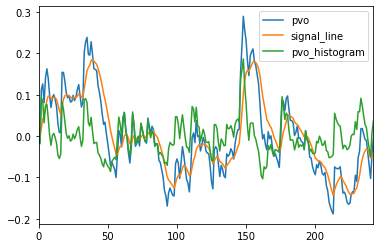

In [179]:
pvo_df.plot()

In [175]:
ppo_df = ppo(df)

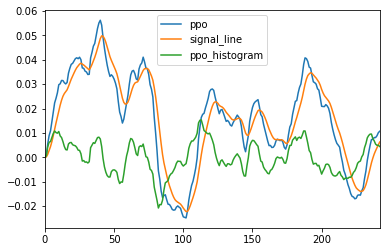

In [176]:
ppo_df.plot()

In [90]:
tp = (df['high'] + df['low'] + df['close'])/3
raw_money_flow = tp * df['vol']

In [92]:
df_t = df.copy()

In [93]:
df_t['rfr'] = raw_money_flow

In [137]:
df_t['change']>0

0      False
1       True
2       True
3      False
4      False
       ...  
238     True
239    False
240     True
241     True
242    False
Name: change, Length: 243, dtype: bool

In [104]:
df_t.rolling(14).apply(lambda x:sum(x['change'] for p in x if p['change'] > 0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [136]:
p_money_flow = df_t.rolling(14).apply(lambda x:sum(p[1]['rfr'] for p in x.iterrows() if p[1]['change'] > 0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'

In [135]:
[p[1]['rfr'] for p in df_t.iterrows()]

[4992919.368799999,
 3845111.1639999994,
 14214189.779133333,
 8431797.808400001,
 3892434.3174,
 12219738.206400001,
 10775340.208533332,
 7072742.612833335,
 5076166.1479,
 5531844.811833334,
 10171332.4459,
 9119447.1336,
 7683449.904,
 6841914.936266667,
 4382777.4662,
 5577780.6531,
 7118444.4224000005,
 22903837.563833337,
 11381195.669333333,
 9048855.108000001,
 7829637.773299999,
 9214380.07,
 11295587.679566665,
 8925554.6919,
 10728894.752333334,
 12856024.081133334,
 9784127.955433331,
 12130738.792266665,
 14128809.936533332,
 14458401.341733333,
 9489205.0851,
 8595895.717066666,
 13521825.7618,
 34614870.445066676,
 24829252.938533332,
 24546368.824933335,
 13817278.850666666,
 21545503.832799997,
 31930605.63536667,
 18398688.933933333,
 16223950.338,
 22780632.612833332,
 22078846.075,
 14223669.127400002,
 17525080.940266665,
 15677425.425999999,
 13154900.675999999,
 13074544.748533333,
 18912659.905333336,
 12232970.758799998,
 11857453.845,
 10915186.752,
 8997260.

In [143]:
def func(df_t):
    print(df_t)
    count = 0
    for p in df_t.iterrows():
        if p[1]['change'] > 0:
            count +=p[1]['rfr'] 
    return count

In [141]:
func(df_t)

1978090911.1825001

In [145]:
df_t

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,rfr
0,242,000001.SZ,20190102,9.39,9.42,9.16,9.19,9.38,-0.19,-2.0256,539386.32,498695.109,4.992919e+06
1,241,000001.SZ,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707,3.845111e+06
2,240,000001.SZ,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888,1.421419e+07
3,239,000001.SZ,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430,8.431798e+06
4,238,000001.SZ,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795,3.892434e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,4,000001.SZ,20191224,16.23,16.50,16.23,16.40,16.24,0.16,0.9852,459128.42,752351.618,7.518993e+06
239,3,000001.SZ,20191225,16.45,16.56,16.24,16.30,16.40,-0.10,-0.6098,414917.98,679664.596,6.790824e+06
240,2,000001.SZ,20191226,16.34,16.48,16.32,16.47,16.30,0.17,1.0429,372033.86,610381.757,6.110036e+06
241,1,000001.SZ,20191227,16.53,16.93,16.43,16.63,16.47,0.16,0.9715,1042574.72,1741473.179,1.737277e+07


In [ ]:
def roll(df: pd.DataFrame, window: int, **kwargs):
    """
    rolling with multiple columns on 2 dim pd.Dataframe
    * the result can apply the function which can return pd.Series with multiple columns

    Reference:
    https://stackoverflow.com/questions/38878917/how-to-invoke-pandas-rolling-apply-with-parameters-from-multiple-column

    :param df:
    :param window:
    :param kwargs:
    :return:
    """

    # move index to values
    v = df.reset_index().values

    dim0, dim1 = v.shape
    stride0, stride1 = v.strides

    stride_values = stride(v, (dim0 - (window - 1), window, dim1), (stride0, stride0, stride1))

    rolled_df = pd.concat({
        row: pd.DataFrame(values[:, 1:], columns=df.columns, index=values[:, 0].flatten())
        for row, values in zip(df.index[window - 1:], stride_values)
    })

    return rolled_df.groupby(level=0, **kwargs)


def own_func(df):
    """
    attention: df has MultiIndex
    :param df:
    :return:
    """

    return pd.Series([df["C"].mean(), df["C"].max() + df["D"].min()])

In [144]:
df_t.rolling(14).apply(lambda x:func(x), raw=True)

[ 9.39  9.18  9.24  9.84  9.73  9.74  9.87 10.11 10.22 10.11 10.24 10.54
 10.34 10.34]


AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'

In [138]:
sum(p[1]['rfr'] for p in df_t.iterrows() if p[1]['change'] > 0)

1978090911.1825001

In [ ]:
roll()

In [102]:
sum(df_t['rfr'])

3436558884.6411

In [91]:
raw_money_flow.rolling(14).apply()

0      4.992919e+06
1      3.845111e+06
2      1.421419e+07
3      8.431798e+06
4      3.892434e+06
           ...     
238    7.518993e+06
239    6.790824e+06
240    6.110036e+06
241    1.737277e+07
242    1.605488e+07
Length: 243, dtype: float64

In [84]:
macd_ret = macd(df)

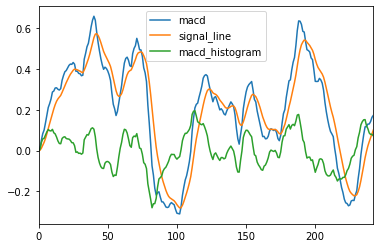

In [85]:
macd_ret.plot()

In [75]:
mass_index_ret = mass_index(df)

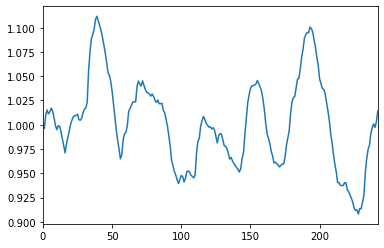

In [76]:
mass_index_ret.plot()

In [71]:
force_index_ret = force_index(df)

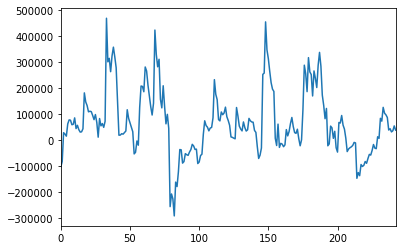

In [72]:
force_index_ret.plot()

In [62]:
emv_ret = emv(df)

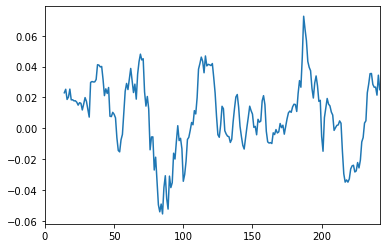

In [63]:
emv_ret.plot()

In [46]:
dpo_ret = dpo(df)

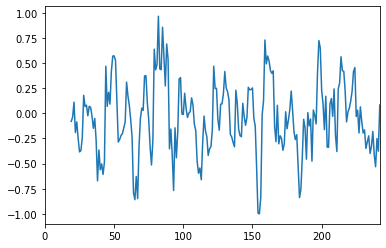

In [51]:
dpo_ret.plot()

In [33]:
cv = coppock_curve(df)

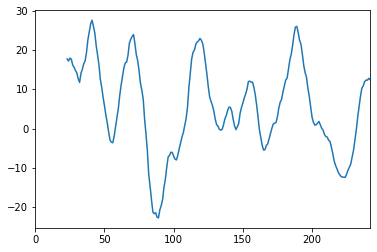

In [35]:
cv.plot()

In [8]:
roc_ret = roc(df)

In [360]:
cci_ret= cci(df)

In [361]:
cci_ret

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
238    87.075658
239    75.972853
240    75.631855
241    99.627726
242    61.498080
Length: 243, dtype: float64

In [353]:
df['high']

0       9.42
1       9.33
2       9.82
3       9.85
4       9.74
       ...  
238    16.50
239    16.56
240    16.48
241    16.93
242    16.63
Name: high, Length: 243, dtype: float64

In [355]:
df['high'].rolling(2).apply(lambda x: abs(x-x.mean()).sum())/2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


0        NaN
1      0.045
2      0.245
3      0.015
4      0.055
       ...  
238    0.090
239    0.030
240    0.040
241    0.225
242    0.150
Name: high, Length: 243, dtype: float64

In [349]:
pc = price_channel(df)

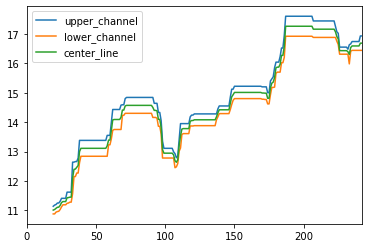

In [350]:
pc.plot()

In [346]:
rsi_ret = rsi(df)

In [347]:
rsi_ret

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
238    71.541502
239    67.330677
240    67.330677
241    74.596774
242    75.203252
Name: change, Length: 243, dtype: float64

In [322]:
df[df['change']>0]

,index,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
1,241,000001.SZ,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707
2,240,000001.SZ,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888
5,237,000001.SZ,20190109,9.74,10.08,9.70,9.94,9.66,0.28,2.8986,1233486.36,1229465.116
6,236,000001.SZ,20190110,9.87,10.20,9.86,10.10,9.94,0.16,1.6097,1071817.66,1079711.035
7,235,000001.SZ,20190111,10.11,10.22,10.05,10.20,10.10,0.10,0.9901,696364.55,708001.802
...,...,...,...,...,...,...,...,...,...,...,...,...
235,7,000001.SZ,20191219,16.55,16.74,16.44,16.55,16.46,0.09,0.5468,675536.76,1119925.969
236,6,000001.SZ,20191220,16.55,16.68,16.44,16.59,16.55,0.04,0.2417,644478.38,1067869.779
238,4,000001.SZ,20191224,16.23,16.50,16.23,16.40,16.24,0.16,0.9852,459128.42,752351.618
240,2,000001.SZ,20191226,16.34,16.48,16.32,16.47,16.30,0.17,1.0429,372033.86,610381.757


In [271]:
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20191230,16.46,16.63,16.10,16.57,16.63,-0.06,-0.3608,976970.31,1603152.786
1,000001.SZ,20191227,16.53,16.93,16.43,16.63,16.47,0.16,0.9715,1042574.72,1741473.179
2,000001.SZ,20191226,16.34,16.48,16.32,16.47,16.30,0.17,1.0429,372033.86,610381.757
3,000001.SZ,20191225,16.45,16.56,16.24,16.30,16.40,-0.10,-0.6098,414917.98,679664.596
4,000001.SZ,20191224,16.23,16.50,16.23,16.40,16.24,0.16,0.9852,459128.42,752351.618
...,...,...,...,...,...,...,...,...,...,...,...
238,000001.SZ,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795
239,000001.SZ,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430
240,000001.SZ,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888
241,000001.SZ,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707


In [259]:
df['close'].ewm??

Object `ewm` not found.


In [318]:
co = chaikin_oscillator(df)

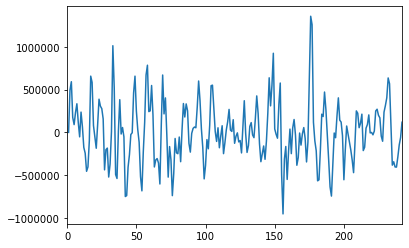

In [319]:
co.plot()

In [253]:
cmf_ret = cmf(df)

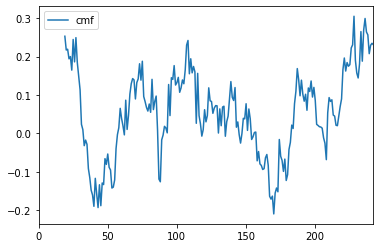

In [254]:
cmf_ret.plot()

In [219]:
tr, atr = true_range(df)

In [221]:
atr

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
238    0.255000
239    0.233571
240    0.262143
241    0.261429
242    0.267143
Length: 243, dtype: float64

In [315]:
adx_ret = adx(df)

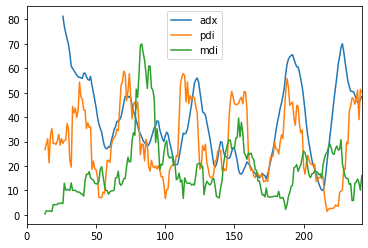

In [317]:
adx_ret.plot()

In [310]:
aroon_ret = aroon(df)

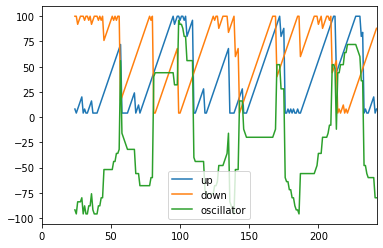

In [311]:
aroon_ret.plot()

In [250]:
adl_ret = adl(df)

In [269]:
adl_ret['adl']

0               NaN
1      5.472545e+05
2      1.170147e+05
3      6.620589e+04
4     -1.402904e+05
           ...     
238    1.904723e+05
239   -1.341294e+05
240    1.135555e+06
241    1.320239e+06
242   -2.302290e+05
Name: adl, Length: 243, dtype: float64

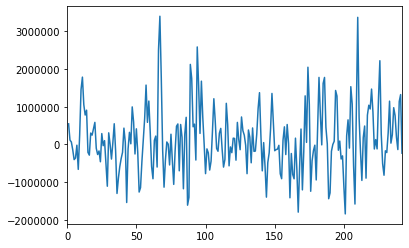

In [267]:
adl_ret['adl'].plot()

In [308]:
ret = bollinger_bands(df)

In [228]:
ret.Percent_Band

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
238    0.028166
239    0.113348
240    0.149635
241   -0.031141
242    0.001039
Name: Percent_Band, Length: 243, dtype: float64

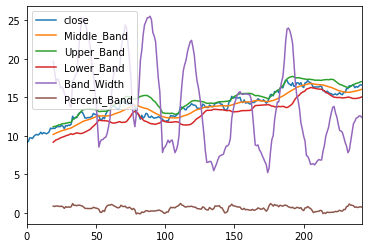

In [309]:
ret.plot()